<a href="https://colab.research.google.com/github/KGzB/CAS-Applied-Data-Science/blob/master/Module-2/CAS-D3-Hypothesis-Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook 4, Module 2, Statistical Inference for Data Science, CAS Applied Data Science, 2024-08-29, A. Mühlemann, University of Bern.

*This notebook is based on the notebook by S. Haug and G. Conti from 2020*

## 4. Hypothesis Testing

Practice various tests with the Python scipy stats module.

**Average expected study time :** 3x45 min (depending on your background)

**Learning outcomes :**

- Know the hypothesis testing vocabulary
- Can check normality based on Q-Q-Plots
- Can perform normality tests of samples (Agostino-Pearson test, Shapiro-Wilk)
- Can perform t-Test on a single sample (testing against a given mean, gaussian)
- Can perform a Wilcoxon on a single sample (testing against a given median, not gaussian, only symmetric assumption)
- Can comparing two groups of data, e.g. treated and control, know which tests are suited for which cases
- Can perform some ANOVA tests

**Bonus skills**
- More Python tricks
- Get to know the Python stats module better: https://docs.scipy.org/doc/scipy/reference/stats.html

**Literature examples**

- https://en.wikipedia.org/wiki/Statistical_hypothesis_testing
- http://greenteapress.com/wp/think-stats-2e/ (online book covering most of the CAS Module 2)

- For life sciences (bioinformatics) for example
https://cran.r-project.org/doc/contrib/Krijnen-IntroBioInfStatistics.pdf
- (Particle) Physics
http://pdg.lbl.gov/2018/reviews/rpp2018-rev-statistics.pdf


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from scipy import stats

## 4.1 Summary of the main points

The hypothesis being tested is called the *null hypothesis*. When doing a statistical test, the test statistic of a sample is calculated and and then we check how probable this value is given the null hypothesis. To this end, we look a the p-value.

More precisely, the p-value is the probability of obtaining such a sample if the null hypothesis is true. A significance level of 5% is often used as the threshold where you say, this is so unlikely that I consider the null hypothesis as wrong. However, 5% still means that this happens in 5 out of 100 times.

Depending on your working hypothesis $H_1$, you are either interested in a one-, or two-sided test. Roughly speaking you'll use a one-tailed (``` greater, less ```) test, when having a hypothesis about the direction of an effect e.g. group 1 is better that group 2. You'll use a two-tailed test (```two-sided```) when you just want to show that the two groups are different.
For more insight on this, check out this link https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-what-are-the-differences-between-one-tailed-and-two-tailed-tests/

In Python (an R) you can adapt the direction of you test with the argument via

```
alternative='two-sided', 'less', 'greater'
```
To avoid confusion the code below below always uses ```alternative='two-sided```.



### Error types and statistical power

- Type I : Reject the null hypothesis due to a fluctuation (false positive)
- Type II : Keep the null hypothesis by interpreting a real effect as a fluctuation (false negative)
- (Type 0 : Make the right conclusion but asking the wrong question)

People may talk about the **statistical power** of their experiment. This is a number between 0 and 1 telling how often your experiment would lead to a type II error. So a high power (close to 1) means rare type II errors. The statistical power is infuenced by your significance criterion, the (physical) magnitude of your effect, the sample size ("statistics").

### Many tests

There are many tests on the market and some or most of them are implemented in Python (or R). It is impossible to look at all the tests that exist, since basically for every scenario there is another test. We therefore focus on a few useful cases. You would look up suiteable tests for your analysis. The important thing is to know what a test assumes (distribution etc) and how to interprete the result and if you can trust the result


## 4.2 Normality

There are different approaches to deciding whether the normality assumption is satisfied. There are statistical tests as well as grafical approaches. We first look at a graphical approach named Q-Q-Plot

### 4.2.1 Q-Q-Plot


A Q-Q (quantile-quantile) plot, plots the distribution of the data against the expected normal distribution by comparing their quantiles. For normally distributed data, observations should lie approximately on a straight line. If the data is not normal, the points deviate from a straight line.

Let us first generate some normal data, to see how a Q-Q-Plot ideally should look like.

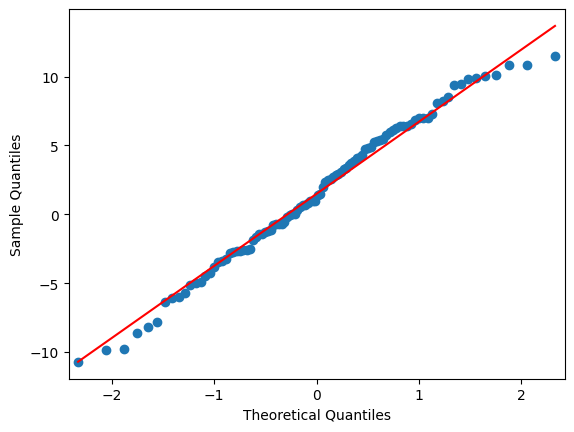

In [2]:
n = 100
np.random.seed(26082021) # By fixing the seed, you can make the generation reproducible
# Generate a data sample of size n
a = np.random.normal(2, 5, size=n)
fig=sm.qqplot(a, line='s')
plt.show()

Now let us check what happens if the normality assumption is certainly violated.

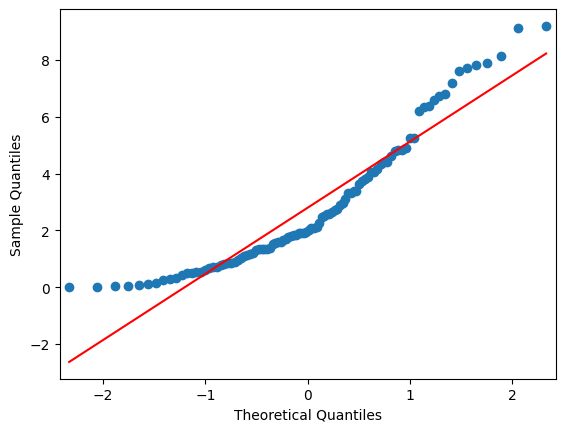

In [3]:
n = 100
np.random.seed(26082021) # By fixing the seed, you can make the generation reproducible
# Generate a data sample of size n from a chi-square distribution
b = np.random.chisquare(df=3, size=n)
fig=sm.qqplot(b, line='s')
plt.show()

Now let us go back to the balance data set. Often one says that the height is a normally distributed variable. Let us now check whether this could be the case in our data set.

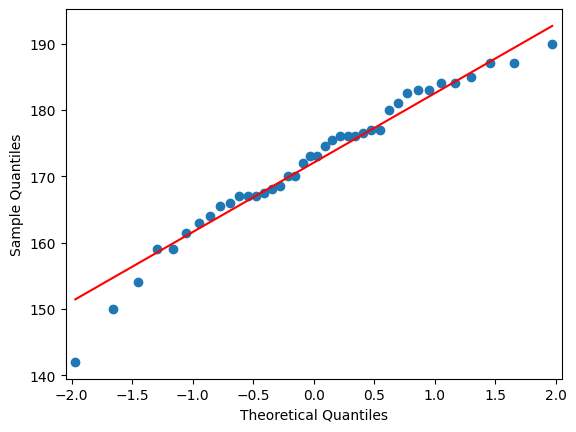

In [4]:
# Load Data
url = "https://github.com/KGzB/CAS-Applied-Data-Science/blob/master/Module-2/balance.csv?raw=true"
df = pd.read_csv(url,sep=";")

# make a separate data set containing just the different participants
participants = df[['Subject', 'Sex', 'Age', 'Height',	'Weight']].drop_duplicates()

# Q-Q-Plot of height
fig=sm.qqplot(participants['Height'], line='s')
plt.show()

The tails seem to differ a bit from a normal distribution. Moreover, there seems to be some small pattern present, since the sample quantiles are sometimes systematically above and the systematically below the line. When one is not sure on how the decide, it's helpful go generate some normal samples of the same size and compare their Q-Q-Plots to the one at hand.

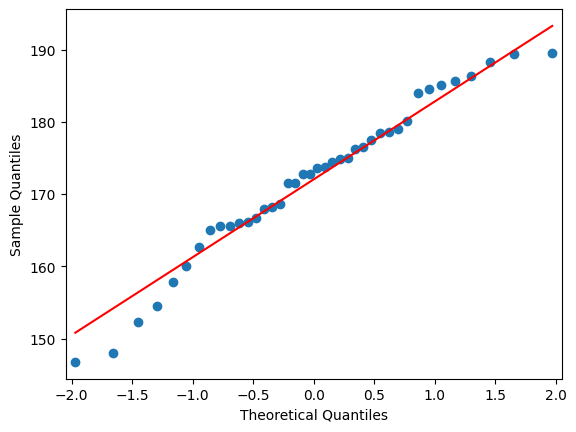

In [9]:
# Generate a data sample of size n
c = np.random.normal(participants['Height'].mean(), participants['Height'].std(), size=len(participants['Height']))
fig=sm.qqplot(c, line='s')
plt.show()

If we rerun the above code several times, it seems that a normality assumption is justified.

### 4.2.2 Normality test

An alternative to Q-Q-Plots is provided by normality tests.

They can be performed for each column of data. Each normality test reports a p-value that answers this question:

If you randomly sample from a Gaussian population, what is the probability of obtaining a sample that deviates from a Gaussian distribution as much (or more so) as this sample does?

Normality tests are not good for small samples (<10-20 values). You can do it, but the interpration of the output is not straight forward.

There are several normality tests in the Python stats module:
- D’Agostino-Pearson
- Shapiro-Wilk
- Kolomogorv-Smirnov

Many people prefer to use the first one. But the others are also widely used. Personally, I often work with Q-Q-Plots because that way I get a better impression on what areas might be critical and what not. But many people prefer tests because the decision is easier to make, however that may also lead to a false sense of security.

What is a bit different with normality test compared to other tests, is that we cannot test for normality but rather against normality. Meaning that if the p-value is small that indicates that the data is **not** normally distributed. Hence, we are rather hoping for a p-value close to 1.

https://docs.scipy.org/doc/scipy/reference/stats.html


Let us perform the D’Agostino-Pearson test for examples we considered with the Q-Q-Plots. First the data generated from a normal distribution.

In [10]:
k2, p = stats.normaltest(a) # D Agostino-Pearson. The method returns the test statistic value and the p-value
alpha = 0.001 # Rejection criterion defined by you
print('Alpha = ',alpha)
print('p = ',p)
if p < alpha:  # null hypothesis: x comes from a normal distribution
     print("The null hypothesis can be rejected")
else:
  print("The null hypothesis cannot be rejected")

Alpha =  0.001
p =  0.23116477867149146
The null hypothesis cannot be rejected


This is not very surprising as we generated the data from a normal distribution. Now let us look at the data generated from a Chi-square distribution.

In [11]:
k2, p = stats.normaltest(b) # D Agostino-Pearson. The method returns the test statistic value and the p-value
alpha = 0.001 # Rejection criterion defined by you
print('Alpha = ',alpha)
print('p = ',p)
if p < alpha:  # null hypothesis: x comes from a normal distribution
     print("The null hypothesis can be rejected")
else:
  print("The null hypothesis cannot be rejected")

Alpha =  0.001
p =  0.0008658946948332712
The null hypothesis can be rejected


Indeed the normality test suggest that we should reject the normality assumption. Finally let us looks again at *Height* from our dataframe.

In [12]:
k2, p = stats.normaltest(participants['Height']) # D Agostino-Pearson. The method returns the test statistic value and the p-value
alpha = 0.001 # Rejection criterion defined by you
print('Alpha = ',alpha)
print('p = ',p)
if p < alpha:  # null hypothesis: x comes from a normal distribution
     print("The null hypothesis can be rejected")
else:
  print("The null hypothesis cannot be rejected")

Alpha =  0.001
p =  0.16152714458037018
The null hypothesis cannot be rejected


Considering the Q-Q-Plot we concluded that the normality assumption is justified. The D’Agostino-Pearson test confirms this conclusion.


What does this p-value mean?

We can also try the shapiro test that the stat module offers:

In [13]:
s,p = stats.shapiro(participants['Height'])
print('Test statistic = ',s,' p-value =',p)

Test statistic =  0.9667359772626742  p-value = 0.2822959154977096


## 4.3 One-sample tests
Having seen how we can check for normality let us introduce the tests seen on the slides.
More details on the specific tests will be given in the presentations tomorrow. Nonetheless it's helpful to have an overview on how the tests are performed.
To illustrate the 1-sample tests we again look at the feature *Height*. The avarage Swiss male has a height of 177cm. Let us now check whether the male Australian participants in this experiments do have the same average heigth as a Swiss male.

### 4.3.1 t-Test

The assumptions on the onesample t-Test are that the data stems from a random draw and that the variable is approximately normal distribution. With our previous considerations about normality, it is therefore justified to perform a t-test.

In [14]:
stats.ttest_1samp(a=participants[participants['Sex']=='male']['Height'],popmean=177, alternative='two-sided')

TtestResult(statistic=np.float64(2.4795712861170087), pvalue=np.float64(0.022695828454899942), df=np.int64(19))

**Interpretation:** With a certainty of 95% we reject the null hypothesis that the poulation has an real mean height of 177cm.

### 4.3.2 Wilcoxon signed rank test

If normality is not satisfied but the distribution can be assumed to be symmetric we can perform a one-sample Wilcoxon signed rank test. It works similar to the t-test but we have to subtract the guessed population mean.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html#scipy.stats.wilcoxon

In [15]:
stats.wilcoxon(participants[participants['Sex']=='male']['Height']-177, alternative='two-sided')

WilcoxonResult(statistic=np.float64(38.0), pvalue=np.float64(0.03841859384167645))

We come to the same conclusion as with the t-Test. However, when looking at the p-value we can see, that the Wilcoxon signed rank test is more conservative than the t-test.

### 4.3.3 Sign test

If the distribtuion is neither normal nor symmetric we can perform a sign-test. For some reason, only the two-sided version is implemented. But the sign-test is fairly easy to calculate by hand.

https://www.statsmodels.org/stable/generated/statsmodels.stats.descriptivestats.sign_test.html

https://en.wikipedia.org/wiki/Sign_test

In [16]:
import statsmodels.stats.descriptivestats as dstat
dstat.sign_test(participants[participants['Sex']=='male']['Height'], mu0=177)

(np.float64(2.0), np.float64(0.480682373046875))

This test is even more concervative. We can see that in this case, we could not reject the null hypothesis.

## 4.4 Two-sample Tests

In many experiments one uses two groups, e.g. a treated group and a control group which is not treated. The goal is then to check the effect of the treatment.

One way to answer this, is to check how much the treated group differs from the control group. Python stats module offer several tests for do this.

If the data is "paired", this can be used in the tests (they get better because there is more "information or structure" in the data). So we need to know what paired data is in order to choose the right test.

**Paired/related data**
- Repeated measurements on the same object/individual, e.g. before and after treatment

**Unpaired/independent data**
- Independent, e.g. from separate individuals

### 4.4.1 t-test for normally distributed unpaired data with not assuming equal variance

Let us perform a test height to compare the height of the participants with respect to the genders. To perform a t-test we should argue why it reasonable that out data is normally distributed.
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html#scipy.stats.ttest_ind

In [17]:
k2, p = stats.normaltest(participants[participants['Sex']=='male']['Height']) # D Agostino-Pearson test for male height
print("p-value = %1.2f" % p)

p-value = 0.89


In [18]:
k2, p = stats.normaltest(participants[participants['Sex']=='female']['Height']) # D Agostino-Pearson test for female height
print("p-value = %1.2f" % p)

p-value = 0.02


The height of the females is likely not normally distributied. Thus, we are not justified to perform a t-Test. We nevertheless perform one here, so that you can see how it is done in Python. For this test we furthermore assume that the variance/standard deviation of the height is different for both genders.

In [19]:
stats.ttest_ind(participants[participants['Sex']=='male']['Height'],
                participants[participants['Sex']=='female']['Height'],
                equal_var = False, alternative='two-sided') # False means we don't assume equal variances (Welsch's t-test)

TtestResult(statistic=np.float64(7.315209799153602), pvalue=np.float64(1.9610869691054646e-08), df=np.float64(33.47945015319325))

**Interpretation :** It is extremly unlikely that these samples would come from a population with the same mean since the p-value is very small.

### 4.4.2 t-test for normally distributed unpaired data assuming equal variance

If we are in the same case as above but have reason to believe that the variance / standard deviation of the height is equal in both genders, we can perform a t-test for this case.

In [20]:
stats.ttest_ind(participants[participants['Sex']=='male']['Height'],
                participants[participants['Sex']=='female']['Height'],
                equal_var = True, alternative='two-sided') # False means we don't assume equal variances (Welsch's t-test)

TtestResult(statistic=np.float64(7.315209799153601), pvalue=np.float64(9.248533903921777e-09), df=np.float64(38.0))

**Interpretation :** It is extremly unlikely that these samples would come from a population with the same mean and the same variance.




### 4.4.3 Mann-Whitney U for *not* normally distributed unpaired data

Compute the Mann-Whitney U test on samples x and y. Only use with more than 20 data points
http://localhost:8888/notebooks/work/SDA-4-Hypothesis-Testing.ipynb#t-Test

We have checked for normality of the height within both genders and seen that the female heights in our sample are not normally distributed. Thus, it is actually not justified to perform a t-test. The non-parametric alternative is the Mann-Whitney-U-test

In [21]:
stats.mannwhitneyu(participants[participants['Sex']=='male']['Height'],
                   participants[participants['Sex']=='female']['Height'],
                   alternative='two-sided')

MannwhitneyuResult(statistic=np.float64(392.0), pvalue=np.float64(2.1747955363354372e-07))

Again we observe a very small p-value suggesting that the expected height of males differs of the expected height of females.

### 4.4.4 t-test for normally distributed paired data

Let us now move on to paired data. This is for example the case if we want to compare the balance scores on the different surfaces. This is paired data because all participants had to all experiments.

The normality assumption is clearly not fulfilled because the score only takes values 1-4. Nontheless we perform here first a t-test so that you can see how it's done in Python.

In [22]:
normal = df[df['Surface']=='norm']
foam = df[df['Surface']=='foam']

stats.ttest_rel(normal['CTSIB'],foam['CTSIB'], alternative='two-sided')

TtestResult(statistic=np.float64(-21.030247639341116), pvalue=np.float64(2.7665007095339303e-56), df=np.int64(239))

As expected the p-value is very small meaning that the expected balance score differs between the two surfaces.


### 4.4.4 Wilcoxon signed-rank test for *not* normally distributed paired data

The Wilcoxon signed-rank test is a non-parametric statistical hypothesis test used to compare two related samples, matched samples, or repeated measurements on a single sample to assess whether their population mean ranks differ (i.e. it is a paired difference test). It can be used as an alternative to the paired Student's t-test, t-test for matched pairs, or the t-test for dependent samples when the population cannot be assumed to be normally distributed.
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html#scipy.stats.wilcoxon

As previously argued when considering the *CTSIB*, it makes no sense to assume normality. Thus, a much better suited test for this question is a Wilcoxon signed-rank test.

In [23]:
stats.wilcoxon(normal['CTSIB'],foam['CTSIB'], alternative='two-sided')

WilcoxonResult(statistic=np.float64(0.0), pvalue=np.float64(1.0942711294559511e-35))

Again p-value is very small meaning that the expected balance score differs between the two surfaces.


## 4.5 ANOVA tests (analysis of variance)

Python stats module provides a one-way Anova test. The one-way ANOVA tests the null hypothesis that two or more groups have the same population mean (a generalisation of the t-test to more than two samples). The test is applied to samples from two or more groups, possibly with differing sizes.

Please read the documentation about assumptions before using it:
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html#scipy.stats.f_oneway

When we want to compare the balance score with respect to vision we have three groups (open, closed, dome). Thus, the above tests are not suitable. An alternative would be an ANOVA (which also relies on normality!). We should actually perform a repeated measures ANOVA here, because all participants were evaluated with all types of vision. But this goes beyond the scope of this course.

In [24]:
open = df[df['Vision']=='open']
closed = df[df['Vision']=='closed']
dome = df[df['Vision']=='dome']

stats.f_oneway(open['CTSIB'],closed['CTSIB'],dome['CTSIB'])


F_onewayResult(statistic=np.float64(58.186141810505376), pvalue=np.float64(2.443895910280489e-23))

The p-value $<$0.05. Thus, we conclude with a certainty of 95% that there is at least one type of vision that have a different expected balance score. To find out more details, we could now do pairwise comparisons.

### Beyond one-way ANOVA

There are examples and code for two-way, three-way and four-way etc ANOVA out there. We don't have the time to discuss them to practise them today. You can do this example if you like (maybe with Iris data):

http://www.pybloggers.com/2016/03/three-ways-to-do-a-two-way-anova-with-python/

In [25]:
from statsmodels.stats.anova import anova_lm